## Data Collection

https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/api-reference/get-search-tweets

In this library we use the Twitter standard search API, which returns a collection of relevant Tweets matching a specified query.

The Search API is not meant to be an exhaustive source of Tweets. **Not all Tweets will be indexed or made available via the search interface**.

https://developer.twitter.com/en/docs/twitter-api/v1/tweets/timelines/guides/working-with-timelines

The Twitter API has several methods, such as GET statuses/user_timeline and GET statuses/home_timeline, which return a timeline of Tweet data. Such timelines can grow very large, so there are limits to how much of a timeline a client application may fetch in a single request. Applications must therefore iterate through timeline results in order to build a more complete list.

In [1]:
########################### Data Collection Functions #####################

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re
import seaborn as sns
from twython import Twython
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation



ACCESS_TOKEN = "761441357315440640-suCCQJo6kuufi3PmcYUl2y9kNyYb8C0"
ACCESS_TOKEN_SECRET = "nN4nX0LhlUZHN31LLYU1neOxg7elvb4LIo9KkX7gMDMaN"
API_KEY = "oMlZlYVi6MerYj7SZzcYWvgVr"
API_SECRET_KEY = "OW8cYRS69LUQ1gD5rKULGi4QtuBoj0OX5hRyJI5HVBbzTLZzam"

STOP_WORDS = ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must',
              "n't", 'need', 'sha', 'wo', 'would', "ca", "na", "rt", "like",
             'u', 'get', 'got']

def collect_tweets(query='', geocode=None, result_type='recent',
                   num_of_page=20, count=100, since=None, until=None):
    '''Collects a number of tweets using Twitter standard search API and 
    returns a list of dictionaries each representing a tweet.

    query: search query
    geocode: Returns tweets by users located within a given radius 
             of the given lat/long. The parameter value is specified 
             by " latitude,longitude,radius "
    result_type: Specifies what type of search results you would prefer to receive. 
                  mixed : Include both popular and real time results in the response.
                  recent : return only the most recent results in the response
                  popular : return only the most popular results in the response.
    num_of_page: number of pages to collect.
    count: The number of tweets to return per page, up to a maximum of 100. 
           Defaults to 15.
    since: Returns tweets created after the given date. 
           Date should be formatted as YYYY-MM-DD. 
           The search index has a 7-day limit.
    until: Returns tweets created before the given date. 
           Date should be formatted as YYYY-MM-DD. 
           The search index has a 7-day limit.
    since_id: Returns results with an ID greater than 
              (that is, more recent than) the specified ID. 
              There are limits to the number of Tweets which 
              can be accessed through the API. If the limit of 
              Tweets has occured since the since_id, the since_id 
              will be forced to the oldest ID available.
    max_id: Returns results with an ID less than 
            (that is, older than) or equal to the specified ID.
    include_entities: The entities node will not be included when set to false.
    '''

    # Authentication
    twitter_obj = Twython(API_KEY, API_SECRET_KEY,
                          ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

    # Use Twitter standard API search
    tweet_result = twitter_obj.search(q=query, geocode=geocode,
                                      result_type=result_type, count=count,
                                      since=since, until=until,
                                      include_entities='true',
                                      tweet_mode='extended', lang='en')

    # In order to prevent redundant tweets explained here
    # https://developer.twitter.com/en/docs/tweets/timelines/guides/working-with-timelines
    # instead of reading a timeline relative to the top of the list
    # (which changes frequently), an application should read the timeline
    # relative to the IDs of tweets it has already processed.
    tweets_list = tweet_result['statuses'] 
    i = 0  # num of iteration through each page
    rate_limit = 1  # There is a limit of 100 API calls in the hour
    while tweet_result['statuses'] and i < num_of_page:
        if rate_limit < 1:
            # Rate limit time out needs to be added here in order to
            # collect data exceeding available rate-limit
            print(str(rate_limit)+' Rate limit!')
            break
        max_id = tweet_result['statuses'][len(
            tweet_result['statuses']) - 1]['id']-1

        tweet_result_per_page = twitter_obj.search(q=query, geocode=geocode,
                                                   result_type=result_type,
                                                   count=count, since=since,
                                                   until=until,
                                                   include_entities='true',
                                                   tweet_mode='extended',
                                                   lang='en',
                                                   max_id=str(max_id))

        tweets_list += tweet_result_per_page['statuses']
        i += 1
        rate_limit = int(twitter_obj.get_lastfunction_header(
            'x-rate-limit-remaining'))

    return tweets_list

def find_hashtags(tweet):
    hashtags = ''
    for i, term in enumerate(tweet):
        hashtags += term['text']+','
    return hashtags
    

def make_dataframe(tweets_list, search_term):
    '''Gets the list of tweets and return it as a pandas DataFrame.
    '''

    df = pd.DataFrame()
    df['tweet_id'] = list(map(lambda tweet: tweet['id'],
                              tweets_list))
    df['user'] = list(map(lambda tweet: tweet['user']
                          ['screen_name'], tweets_list))
    df['time'] = list(map(lambda tweet: tweet['created_at'], tweets_list))
    df['tweet_text'] = list(map(lambda tweet: tweet['full_text'], tweets_list))
    df['location'] = list(
        map(lambda tweet: tweet['user']['location'], tweets_list))
    hashtag = ''
    df['hashtags'] = list(
        map(lambda tweet: find_hashtags(tweet['entities']['hashtags']), tweets_list))
    df['search_term'] = list(map(lambda tweet: search_term if search_term.lower(
    ) in tweet['full_text'].lower() else None, tweets_list))

    return df



############################ Data Cleaning Functions ####################################

def clean_tweet_text(tweet, user_flag=True, urls_flag=True, 
                     punc_flag=True, number_flag=True,
                     special_char_flag=True,
                     stop_word_flag=False):
    '''Clean a tweet by performing the following.

    - Remove username
    - Remove urls
    - Remove all punctuation and special character
    - Remove all stopwords if flag is True
    - Returns a cleaned text
    '''

    # remove the user
    if user_flag:
        tweet = re.sub(r'@[w\w]+', ' ', tweet)

    # remove the urls
    if urls_flag:
        tweet = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', ' ', tweet)

    # replace the negations
    tweet = re.sub(r"n't", ' not', tweet)
    tweet = re.sub(r"N'T", ' NOT', tweet)

    # remove punctuations
    if punc_flag:
        tweet = re.sub('[!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@’…”'']+', ' ', tweet)

    # remove numbers
    if number_flag:
        tweet = re.sub('([0-9]+)', '', tweet)

    # remove special characters
    if special_char_flag:
        tweet = re.sub(r'[^\w]', ' ', tweet)

    # remove double space
    tweet = re.sub('\s+', ' ', tweet)

    if stop_word_flag:
        tweet = ' '.join([word for word in tweet.split() if word.lower(
        ) not in stopwords.words('english')+STOP_WORDS])

    return tweet



############# NLP #############3

def tokenize_tweet(tweet):
    '''Convert the normal text strings in to a list of tokens(words)
    '''
    # Tokenization
    return [word for word in tweet.split()]

    
def create_bag_of_words(tweets, max_df=1.0, min_df=1,
                       max_features=None):
    '''Vectorize the tweets using bag of words.
    
    Return the vectorized/bag of words of tweets
    as well as the features' name.
    
    max_df: float in range [0.0, 1.0] or int, default=1.0
            When building the vocabulary ignore terms that 
            have a document frequency strictly higher than 
            the given threshold (corpus-specific stop words). 
            If float, the parameter represents a proportion 
            of documents, integer absolute counts. 
            This parameter is ignored if vocabulary is not None.

    min_df: float in range [0.0, 1.0] or int, default=1
            When building the vocabulary ignore terms that 
            have a document frequency strictly lower than 
            the given threshold. This value is also called 
            cut-off in the literature. If float, the parameter 
            represents a proportion of documents, integer absolute 
            counts. This parameter is ignored if vocabulary is not None.
    '''
    
    # Vectorization using Countvectorize
    cv = CountVectorizer(analyzer=tokenize_tweet, max_df=max_df, 
                         min_df=min_df, max_features=max_features)
    tweets_bow = cv.fit_transform(tweets)
    feature_names = cv.get_feature_names()
    return tweets_bow, feature_names

def create_tfidf(tweets_bow):
    '''Create the TF-IDF of tweets
    '''
    tfidf_transformer = TfidfTransformer().fit(tweets_bow)
    tweets_tfidf = tfidf_transformer.transform(tweets_bow)
    return tweets_tfidf
    

def sentiment_analysis(tweet):
    '''Takes a tweet and return a dictionary of scores in 4 categories.
    - Negative score
    - Neutral score
    - Positive score
    - Compound score
    
    Special characters and stopwords need to stay in the tweet.
    '''
    
    #create an instance of SentimentIntensityAnalyzer
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(tweet)
    if sentiment_scores['compound'] < -0.2:
        sentiment = 'Negative'
    elif -0.2 <= sentiment_scores['compound'] < 0:
        sentiment = 'Neutral\nNegative'
    elif 0 <= sentiment_scores['compound'] <= 0.2:
        sentiment = 'Neutral\nPositive'
    elif sentiment_scores['compound'] > 0.2:
        sentiment = 'Positive'
    else:
        sentiment = None

    return sentiment



#sklearn.decomposition.LatentDirichletAllocation
def topic_modeling(tweets, num_components=7, 
                   num_words_per_topic=10, 
                   random_state=42,
                   max_df=1.0, min_df=1,
                   max_features=None):
    '''Get all the tweets and return the topics
    and the highest probability words per topic
    '''
    
    #create the bags of words
    tweets_bow, feature_names = create_bag_of_words(tweets, max_df=max_df, 
                                                    min_df=min_df, 
                                                    max_features=max_features)
    
    #create an instace of LatentDirichletAllocation 
    lda = LatentDirichletAllocation(n_components=num_components,
                                    random_state=random_state)
    lda.fit(tweets_bow)
    
    #grab the highest probability words per topic
    words_per_topic = {}
    for index,topic in enumerate(lda.components_):
        words_per_topic[index] = [feature_names[i] for i in topic.argsort()[-15:]]
        
    topic_results = lda.transform(tweets_bow)
    topics = topic_results.argmax(axis=1)
    return topics, words_per_topic
    
    
def find_top_hashtags(hashtags):
    '''Get the hashtag column and find the popular hashtags.
    
    '''
    pass
    
    
    

In [25]:
#test

query = 'Walmart'
#geocode="43.653226,-79.383184,100km" #Toronto
#geocode="49.525238,-93.874023,4000km" #North America
tweets_list = collect_tweets(query=query, geocode="49.525238,-93.874023,4000km")


In [94]:
df = make_dataframe(tweets_list, query)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2095 entries, 0 to 2094
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_id     2095 non-null   int64 
 1   user         2095 non-null   object
 2   time         2095 non-null   object
 3   tweet_text   2095 non-null   object
 4   location     2095 non-null   object
 5   hashtags     2095 non-null   object
 6   search_term  1956 non-null   object
dtypes: int64(1), object(6)
memory usage: 114.7+ KB


In [96]:
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
df.head(400)

,tweet_id,user,time,tweet_text,location,hashtags,search_term
0,1328515200925003778,lglovinsky11,Tue Nov 17 01:48:01 +0000 2020,RT @QasimRashid: COVID19 has closed 20% of sma...,,,Walmart
1,1328514902382817282,FRWessling,Tue Nov 17 01:46:49 +0000 2020,RT @QasimRashid: COVID19 has closed 20% of sma...,"Always Here, Sometimes Now",,Walmart
2,1328514480712650752,PonytailPixie,Tue Nov 17 01:45:09 +0000 2020,RT @QasimRashid: COVID19 has closed 20% of sma...,Sparkle Mountain,,Walmart
3,1328513128754270209,FanWalmart,Tue Nov 17 01:39:47 +0000 2020,RT @WalmartCAGaming: Happy Monday! A quick upd...,Walmart Canada :),"PS5,",Walmart
4,1328512926173589505,avmoca,Tue Nov 17 01:38:58 +0000 2020,RT @QasimRashid: COVID19 has closed 20% of sma...,,,Walmart
5,1328512860721459201,MarthaLynneOwe1,Tue Nov 17 01:38:43 +0000 2020,RT @QasimRashid: COVID19 has closed 20% of sma...,Southern Maine,,Walmart
6,1328512705557311488,tightenupjit,Tue Nov 17 01:38:06 +0000 2020,Bout to hit this Walmart truck for this ps5,Florida,,Walmart
7,1328512627589468161,jjj5819,Tue Nov 17 01:37:47 +0000 2020,RT @QasimRashid: COVID19 has closed 20% of sma...,Worcester MA,,Walmart
8,1328512204237398020,ymbertmarypaz,Tue Nov 17 01:36:06 +0000 2020,@AcidComment__ Walmart o Pricesmart!,Guatemala,,Walmart
9,1328511952457506821,BBF8droid,Tue Nov 17 01:35:06 +0000 2020,RT @QasimRashid: COVID19 has closed 20% of sma...,Undrainable Swamp,,Walmart


In [97]:
df.to_csv('tweets.csv')

In [3]:
df = pd.read_csv('tweets.csv')

In [4]:
df['clean_text'] = df['tweet_text'].apply(lambda text: clean_tweet_text(text, punc_flag=False, 
                                                                        number_flag=False, special_char_flag=False,))
#df['no_stop_words_text'] = df['tweet_text'].apply(lambda text: clean_tweet_text(text, stop_word_flag=True))

In [5]:
df['sentiment'] = df['clean_text'].apply(lambda tweet: sentiment_analysis(tweet))
#df['compound_scores'] = df['sentiment_scores'].apply(lambda scores_dict: scores_dict['compound'])

In [82]:
df['topics'], words_per_topic = topic_modeling(df['no_stop_words_text'], num_components=7, 
                   num_words_per_topic=10, 
                   random_state=42,
                   max_df=0.7, min_df=5,
                   max_features=250)

In [83]:
words_per_topic

{0: ['coming',
  'Superstore',
  'PS',
  'keep',
  'even',
  'person',
  'yesterday',
  'ok',
  'buying',
  'sell',
  'go',
  'home',
  'open',
  'stores',
  'day'],
 1: ['want',
  'whatever',
  'post',
  'say',
  'bu',
  'Shaming',
  'MBGov',
  'letting',
  'PANDEMIC',
  'fault',
  'small',
  'classist',
  'shopping',
  'people',
  'one'],
 2: ['shuts',
  'commerce',
  'TV',
  'shirts',
  'Manitoba',
  'lockdown',
  'sell',
  'retailers',
  'PS',
  'small',
  'update',
  'new',
  'store',
  'Costco',
  'customers'],
 3: ['independent',
  'forever',
  'founders',
  'richer',
  'B',
  'join',
  'holiday',
  'season',
  'biz',
  'small',
  'made',
  'closed',
  'COVID',
  'Amazon',
  'amp'],
 4: ['ever',
  'resolved',
  'friends',
  'Everyone',
  'site',
  'bots',
  'shit',
  'People',
  'since',
  'ps',
  'going',
  'parking',
  'time',
  'Canada',
  'lot'],
 5: ['back',
  'many',
  'stock',
  'time',
  'make',
  'mask',
  'one',
  'walmart',
  'think',
  'shop',
  'money',
  'buy',
  '

In [21]:
#pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
df.head(400)

,Unnamed: 0,tweet_id,user,time,tweet_text,location,hashtags,search_term,clean_text,no_stop_words_text,sentiment,topics
0,0,1328515200925003778,lglovinsky11,Tue Nov 17 01:48:01 +0000 2020,RT @QasimRashid: COVID19 has closed 20% of sma...,NaN,NaN,Walmart,RT : COVID19 has closed 20% of small biz forev...,COVID closed small biz forever amp made Amazon...,Positive,3
1,1,1328514902382817282,FRWessling,Tue Nov 17 01:46:49 +0000 2020,RT @QasimRashid: COVID19 has closed 20% of sma...,"Always Here, Sometimes Now",NaN,Walmart,RT : COVID19 has closed 20% of small biz forev...,COVID closed small biz forever amp made Amazon...,Positive,3
2,2,1328514480712650752,PonytailPixie,Tue Nov 17 01:45:09 +0000 2020,RT @QasimRashid: COVID19 has closed 20% of sma...,Sparkle Mountain,NaN,Walmart,RT : COVID19 has closed 20% of small biz forev...,COVID closed small biz forever amp made Amazon...,Positive,3
3,3,1328513128754270209,FanWalmart,Tue Nov 17 01:39:47 +0000 2020,RT @WalmartCAGaming: Happy Monday! A quick upd...,Walmart Canada :),"PS5,",Walmart,RT : Happy Monday! A quick update for customer...,Happy Monday quick update customers hopeful cu...,Positive,2
4,4,1328512926173589505,avmoca,Tue Nov 17 01:38:58 +0000 2020,RT @QasimRashid: COVID19 has closed 20% of sma...,NaN,NaN,Walmart,RT : COVID19 has closed 20% of small biz forev...,COVID closed small biz forever amp made Amazon...,Positive,3
...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,1328327448082182144,KwamzOTW,Mon Nov 16 13:21:57 +0000 2020,RT @BallsOnYaHead03: Walmart when they sell al...,USA,NaN,Walmart,RT : Walmart when they sell all of their 6 Ps5...,Walmart sell Ps bots,Neutral Positive,4
396,396,1328327397079461888,VesnaTalan,Mon Nov 16 13:21:45 +0000 2020,RT @CFIB: Important email to CFIB from @mcnall...,NaN,NaN,NaN,"RT : Important email to CFIB from : ""As Manito...",Important email CFIB Manitobans owning indepen...,Negative,3
397,397,1328326835558633473,janellew76,Mon Nov 16 13:19:31 +0000 2020,@MistyBoudrie @FOX2News @realDonaldTrump Well ...,"Michigan, USA",NaN,Walmart,Well according to her lockdown the virus is o...,Well according lockdown virus control schools ...,Neutral Positive,5
398,398,1328326263006642181,GerryHGagnon,Mon Nov 16 13:17:14 +0000 2020,RT @CFIB: Important email to CFIB from @mcnall...,NaN,NaN,NaN,"RT : Important email to CFIB from : ""As Manito...",Important email CFIB Manitobans owning indepen...,Negative,3


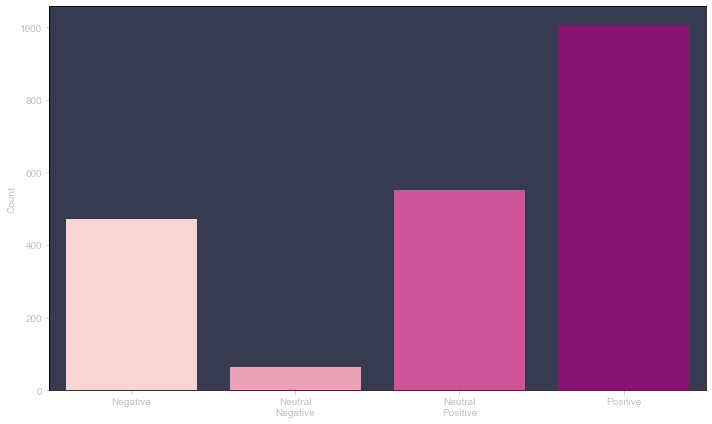

In [8]:
import io
import base64

fig = plt.figure(figsize=(10,6))
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.family'] = "arial"
#plt.rcParams['text.color'] = 'red'
plt.rcParams['axes.facecolor'] =(0.22, 0.23, 0.31, 1)
#plt.rcParams['axes.edgecolor'] =(0.22, 0.23, 0.31, 1)

#sns.set(style="ticks", context="talk")
#plt.style.use("dark_background")


#sequential_colors = sns.color_palette("RdPu", 10)
sentiment_plot = sns.countplot(df['sentiment'], order=['Negative', 'Neutral\nNegative', 'Neutral\nPositive', 'Positive'], palette="RdPu")
#img=io.BytesIO()
#plt.grid(True, linestyle="--")
#plt.title("Gastos Destinados pelo Governo Federal (2014-2018)\n")
plt.xlabel("")
plt.ylabel("Count", color='silver')

#ax.spines['bottom'].set_color('red')
#ax.spines['top'].set_color('red')
#fig.yaxis.label.set_color('red')
plt.tick_params(colors='silver')

plt.tight_layout()
#plt.axis("off")
plt.show(sentiment_plot)
#plt.savefig(img,format='png')
fig.savefig('sentiment_plot.png', facecolor=(0.22, 0.23, 0.31, 1),edgecolor=(0.22, 0.23, 0.31, 1) )
#img.seek(0)
#figure_url = base64.b64encode(img.getvalue()).decode()
#plt.close()
#print('data:image/png;base64,{}'.format(figure_url))


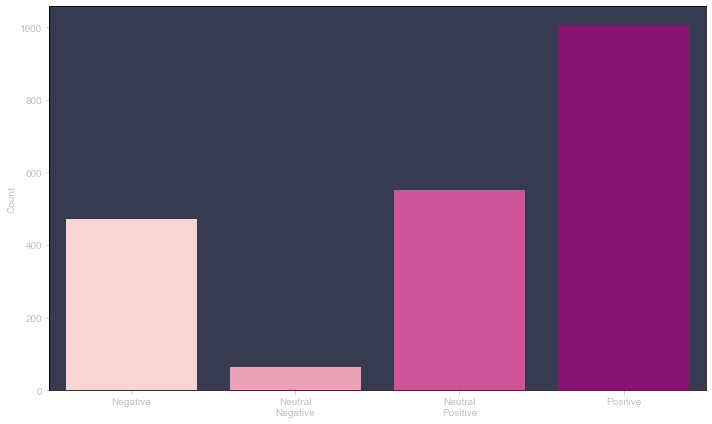

In [12]:
fig = plt.figure(figsize=(10, 6))
sns.countplot(df['sentiment'], order=['Negative', 'Neutral\nNegative', 'Neutral\nPositive', 'Positive'],
              palette="RdPu")
plt.rcParams['font.family'] = "arial"
plt.rcParams['axes.facecolor'] = (0.22, 0.23, 0.31, 1)
plt.xlabel("")
plt.ylabel("Count", color='silver')
plt.tick_params(colors='silver')
plt.tight_layout()
fig.savefig('sentiment_plot.png', facecolor=(
    0.22, 0.23, 0.31, 1), edgecolor=(0.22, 0.23, 0.31, 1))

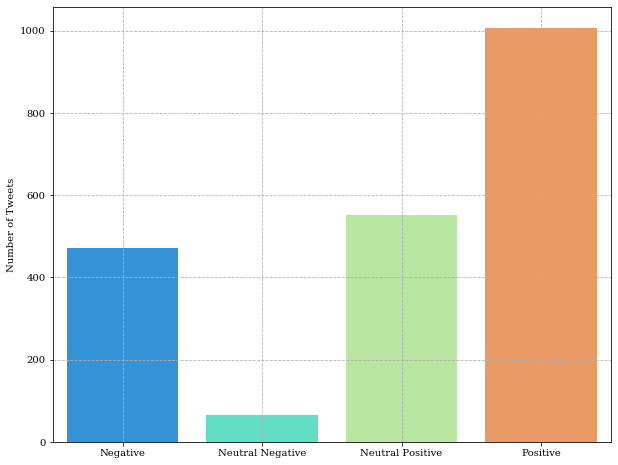

In [52]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.family'] = "serif"

#plt.figure(figsize=(8,6))
#sns.set_style('whitegrid')
#sns.set_context('paper',font_scale=1.5)
#plt.style.use('dark_background')
#sns.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'})
sentiment_plot = sns.countplot(df['sentiment'], order=['Negative', 'Neutral Negative', 'Neutral Positive', 'Positive'], palette='rainbow')


plt.xticks(rotation=0)
plt.grid(True, linestyle="--")
#plt.title("Gastos Destinados pelo Governo Federal (2014-2018)\n")
plt.xlabel("")
plt.ylabel("Number of Tweets")
plt.show()

In [72]:
sentiment_plot.figure.savefig('sentiment_plot.jpeg',  dpi=400) 

In [33]:
df.loc[1]['tweet_text']

'RT @QasimRashid: COVID19 has closed 20% of small biz forever &amp; made Amazon &amp; Walmart founders $133B richer😳\n\nThis holiday season—join the #…'

In [40]:
df.loc[341]['clean_text']

'RT Pretty Please #Win $100 your way!! Target? Walmart? iTunes? Best Buy? PayPal? Single Blog #Giveaway! WW 11/30 //www.peanutbutterandwhine.com/100-your-way-giveaway-november-2020/'

In [35]:
df.loc[341]['no_stop_words_text']

'Pretty Please Win way Target Walmart iTunes Best Buy PayPal Single Blog Giveaway WW www peanutbutterandwhine com way giveaway november'

In [19]:
df.loc[341]['hashtags']

'Win,Giveaway,'

In [83]:
df.loc[1]['sentiment_scores']

{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compound': 0.5267}